### Prediction model for DAENERGY

In the following notebook are considered two different approach to predict the price of DAENERGY

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from src.process_data import pivot_data, create_index, clean_data

/Users/david/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### Loading and cleaning data

- Pivot table
- It's considered data from 2017-07-05 to 2017-10-30
- There are some missing values. Those values where computed using replicating the value of the previous observation (To obtain an index with hourly frequency and obtain forecasts using stats models.
- It's created the index with TRADEDATE and HOUROFWEEK. Finally we obtain the exact date and time of trade.


In [3]:
df = pivot_data('data/Data.txt')
df = clean_data(df)
df = create_index(df)

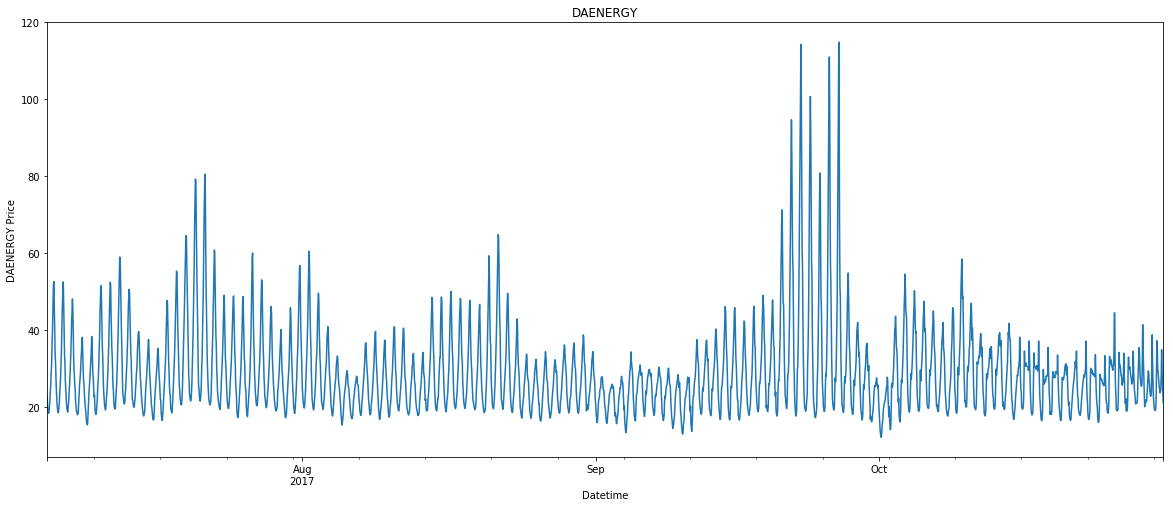

In [4]:
plt.figure(figsize=(20,8))
df.DAENERGY.plot()
plt.title('DAENERGY')
plt.xlabel('Datetime')
plt.ylabel('DAENERGY Price');

In [5]:
df.head()

REGION,TRADEDATE,HOUROFWEEK,CYWG,K2G4,KABE,KABI,KACT,KACY,KADS,KAKR,...,KVCT,KWRI,KYNG,KZZV,LOAD,DAENERGY,RTENERGY,ISOWIND,OUTAGE,hourofday
dt,,,,,,,,,,,,,,,,,,,,,
2017-07-05 01:00:00,2017-07-05,73,67,63,66,77,83,70,80,69,...,81,67,68,70,78515,22.89,22.06,4576.170,14310,01:00:00
2017-07-05 02:00:00,2017-07-05,74,63,62,67,81,84,69,84,63,...,80,68,61,66,68721,20.17,19.97,2952.209,13300,02:00:00
2017-07-05 03:00:00,2017-07-05,75,62,62,66,80,82,69,82,62,...,79,68,61,65,65820,19.42,19.41,2791.408,13300,03:00:00
2017-07-05 04:00:00,2017-07-05,76,61,62,66,78,80,69,80,61,...,78,67,60,64,64262,18.74,19.09,2525.984,13300,04:00:00
2017-07-05 05:00:00,2017-07-05,77,59,61,66,75,79,68,80,60,...,77,67,59,64,64020,18.49,18.64,2520.608,13300,05:00:00


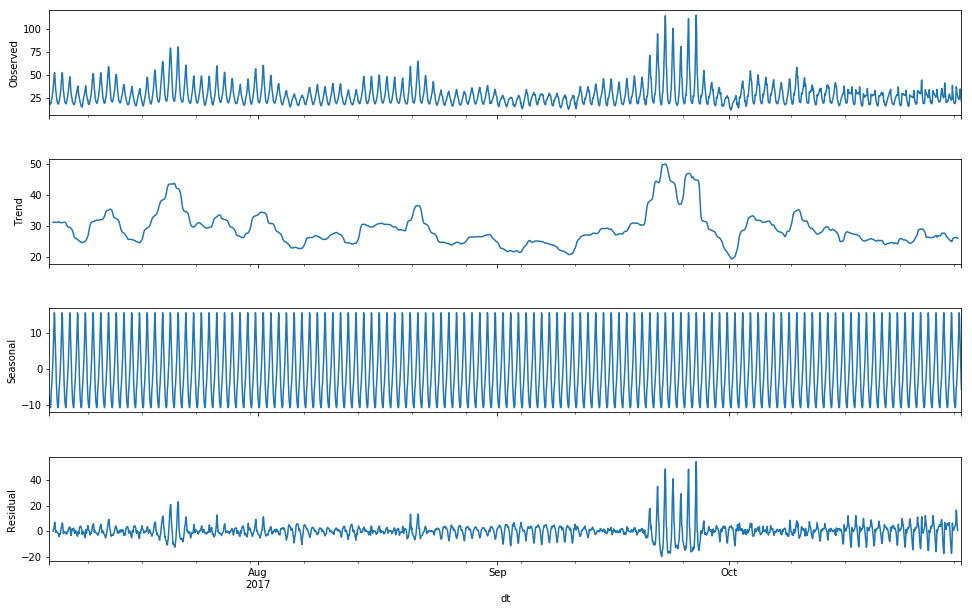

In [6]:
decomposition = seasonal_decompose(df.DAENERGY, freq = 24)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 10)

In [7]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    #rolmean = pd.rolling_mean(timeseries, window=24)
    #rolstd = pd.rolling_std(timeseries, window=24)
    rolmean = pd.Series.rolling(timeseries, window=24, center=False).mean()
    rolstd = pd.Series.rolling(timeseries, window=24, center=False).std()
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

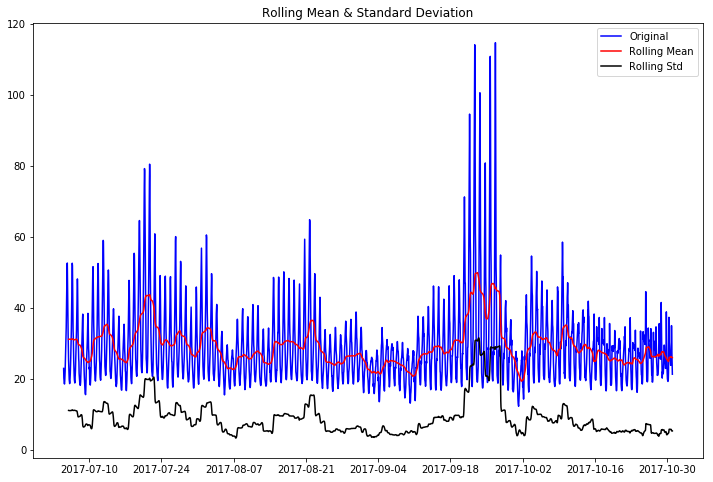

Results of Dickey-Fuller Test:
Test Statistic                   -3.517626
p-value                           0.007546
#Lags Used                       26.000000
Number of Observations Used    2805.000000
Critical Value (1%)              -3.432683
Critical Value (5%)              -2.862571
Critical Value (10%)             -2.567319
dtype: float64


In [8]:
test_stationarity(df.DAENERGY)

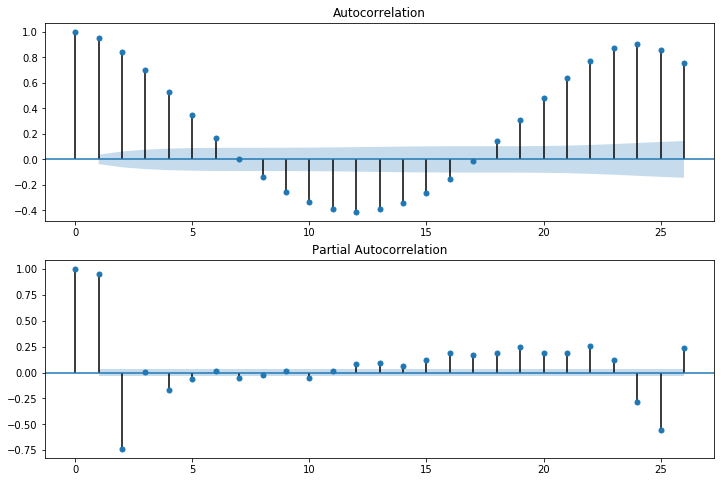

In [9]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.DAENERGY.iloc[25:], lags=26, ax=ax1, alpha = 0.05)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.DAENERGY.iloc[25:], lags=26, ax=ax2,alpha = 0.05)

### SARIMAX MODEL

In [10]:
def create_model(dd, date_predict, exogens):
    mod = sm.tsa.statespace.SARIMAX(dd.DAENERGY,exogen = dd[exogens], trend='n', order=(0,1,0), seasonal_order=(1,1,1,24))
    results = mod.fit()
    print (results.summary())
    pred = results.forecast(24)
    real = df[date_predict].DAENERGY
    RMSE=get_rmse(pred,real)
    plt.plot(df[date_predict].index, real,'g',pred.index,pred,'r' )
    plt.title('RMSE = {:.2f}'.format(RMSE))
    plt.xlabel('time')
    plt.ylabel('Price DAENERGY')
    return results, mod

def get_rmse(pred, real):
    return np.sqrt(((pred-real)**2).sum()/(pred.shape[0]))

In [11]:
temps = []
for col in df.columns.values:
    if len(col)==4:
        temps.append(col)
        
def check_bad_data(df):
    temp = df.groupby('TRADEDATE').count()['HOUROFWEEK']
    temp[temp<24]
    df[df['TRADEDATE'] == '2017-10-25']
    

#### Training the Model
Using historical data until one day before of the day to predict

                                 Statespace Model Results                                 
Dep. Variable:                           DAENERGY   No. Observations:                 1007
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 24)   Log Likelihood               -1510.881
Date:                            Mon, 20 Nov 2017   AIC                           3027.762
Time:                                    19:27:01   BIC                           3042.506
Sample:                                07-05-2017   HQIC                          3033.364
                                     - 08-15-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.6275      0.023     27.832      0.000       0.583       0.672
ma.S.L24      -0.9990      0.810   

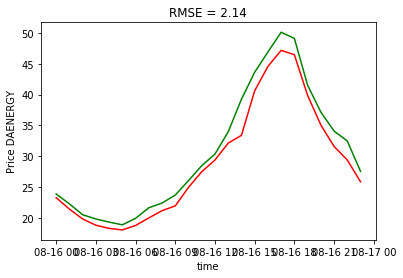

In [12]:
res, mod = create_model(df[:'2017-08-15'],'2017-08-16',temps)

In [13]:
fcast = res.get_forecast(24)
fcast_ci= fcast.conf_int(alpha=0.25)
print(fcast.predicted_mean)
print('')
print('75% of Confidence Interval')
print(fcast_ci)

2017-08-16 00:00:00    23.263397
2017-08-16 01:00:00    21.414675
2017-08-16 02:00:00    19.806091
2017-08-16 03:00:00    18.798893
2017-08-16 04:00:00    18.276033
2017-08-16 05:00:00    18.032493
2017-08-16 06:00:00    18.754600
2017-08-16 07:00:00    19.979790
2017-08-16 08:00:00    21.159397
2017-08-16 09:00:00    21.933292
2017-08-16 10:00:00    24.940790
2017-08-16 11:00:00    27.478009
2017-08-16 12:00:00    29.384096
2017-08-16 13:00:00    32.126541
2017-08-16 14:00:00    33.387377
2017-08-16 15:00:00    40.625879
2017-08-16 16:00:00    44.579501
2017-08-16 17:00:00    47.187716
2017-08-16 18:00:00    46.482910
2017-08-16 19:00:00    39.878468
2017-08-16 20:00:00    35.076029
2017-08-16 21:00:00    31.586414
2017-08-16 22:00:00    29.384350
2017-08-16 23:00:00    25.848000
Freq: H, dtype: float64

75% of Confidence Interval
                     lower DAENERGY  upper DAENERGY
2017-08-16 00:00:00       21.989179       24.537616
2017-08-16 01:00:00       19.612658       23.216693


In [14]:
predict = fcast
predict_ci = fcast_ci

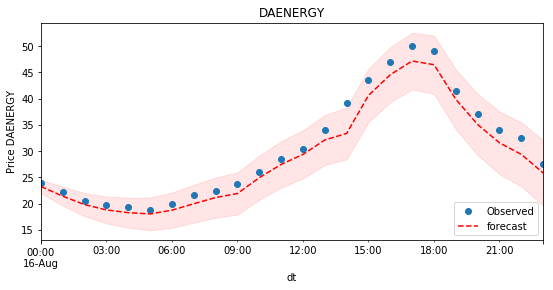

In [15]:
# Graph
fig, ax = plt.subplots(figsize=(9,4))
npre = 24
ax.set(title='DAENERGY', xlabel='Date', ylabel='Price DAENERGY')

# Plot data points
df.loc['2017-08-16', 'DAENERGY'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.loc['2017-08-16'].plot(ax=ax, style='r--', label='forecast')
ci = predict_ci.loc['2017-08-16']
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
legend = ax.legend(loc='lower right')

### AdaBoost Regressor

In [16]:
from sklearn.ensemble import AdaBoostRegressor

#### Cleaning Data for SKLEARN AdaBoost Model

The model will be trained with the historical data until one day before of the prediction required:

In [17]:
sk_df = df[:'2017-08-15'].copy()
sk = sk_df.drop(['TRADEDATE', 'RTENERGY'], axis=1)
sk.hourofday = sk.hourofday.dt.seconds/3600
sk['daybefore'] = sk.DAENERGY.shift(24)
sk = sk.dropna()
y = sk.pop('DAENERGY').values
X = sk.values

#### Creating Model and Training

In [18]:
model = AdaBoostRegressor()
model = model.fit(X,y)

#### Preparing data of 2017-08-16 to make prediction

In [19]:
input_p = df['2017-08-15':'2017-08-16'].copy()
input_p['daybefore'] = input_p.DAENERGY.shift(24)
input_p = input_p.drop(['DAENERGY','TRADEDATE', 'RTENERGY'], axis=1)
input_p.hourofday = input_p.hourofday.dt.seconds/3600
input_p = input_p.dropna()

#### Predictions for 2017-08-16

In [20]:
results = df['2017-08-16'].copy()
pred_ada = model.predict(input_p.values)
results['forecast'] = pred_ada

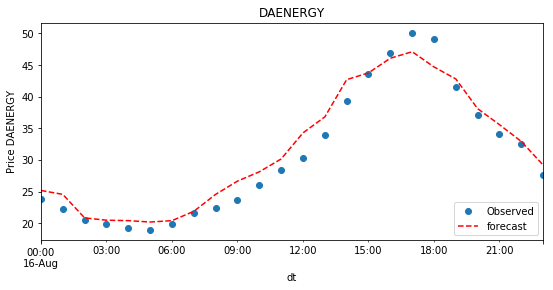

In [21]:
fig, ax = plt.subplots(figsize=(9,4))
npre = 24
ax.set(title='DAENERGY', xlabel='Date', ylabel='Price DAENERGY')

# Plot data points
results.loc['2017-08-16', 'DAENERGY'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
results.forecast.plot(ax=ax, style='r--', label='forecast')
ci = predict_ci.loc['2017-08-16']
#ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
legend = ax.legend(loc='lower right')

In [22]:
RMSE = get_rmse(df['2017-08-16']['DAENERGY'], pred_ada)
print('RMSE for AdaBoost Model: ', RMSE)

RMSE for AdaBoost Model:  2.07504553448


#### Top Features Importance:

In [23]:
input_p.columns.values[np.argsort(model.feature_importances_)[::-1]]


array(['LOAD', 'daybefore', 'KDSM', 'KLRD', 'KMLI', 'KCMI', 'KGRB', 'KELP',
       'KAWM', 'KFWA', 'HOUROFWEEK', 'KFAR', 'KRFD', 'KSAT', 'hourofday',
       'ISOWIND', 'KTEB', 'KINK', 'KCID', 'KCOU', 'KARR', 'KSPI', 'KBAZ',
       'KDEC', 'KDFW', 'KEVV', 'KAMA', 'KCGX', 'KGFK', 'KJCT', 'KATT',
       'KABI', 'KDET', 'KDTW', 'KEWR', 'KBIS', 'KPHL', 'CYWG', 'KSGF',
       'KMLU', 'KMDW', 'KCGI', 'KSPS', 'KERI', 'KUES', 'KLCH', 'KSUX',
       'KGAI', 'KCRP', 'KDOV', 'KABE', 'KDBQ', 'KDCA', 'KESF', 'K2G4',
       'KYNG', 'KDMH', 'KDLH', 'KELD', 'KDTO', 'KZZV', 'KDAY', 'KAKR',
       'KDAL', 'KCVG', 'KAOO', 'KARB', 'KADS', 'KAUS', 'KAVP', 'OUTAGE',
       'KACY', 'KBPT', 'KBRO', 'KBTR', 'KBWI', 'KCAK', 'KCKB', 'KCLE',
       'KCLL', 'KCMH', 'KACT', 'KANJ', 'KCRW', 'KTYR', 'KVCT', 'KFDK',
       'KPIT', 'KMKG', 'KMRB', 'KMSN', 'KMSP', 'KMSY', 'KMWL', 'KODO',
       'KORD', 'KORF', 'KOXB', 'KPIA', 'KPRX', 'KMGW', 'KRDG', 'KRDU',
       'KRIC', 'KROA', 'KSBN', 'KSBY', 'KSJT', 'KSMQ', 'KSTC', '

In [24]:
def train_and_predict(df,date_predict):
    #Prepartinf data to Train
    #print('Preparing data to Train')
    date_p = datetime.datetime.strptime(date_predict, "%Y-%m-%d").date()
    date_limit = (date_p - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
    sk_df = df[:date_limit].copy()
    sk = sk_df.drop(['TRADEDATE', 'RTENERGY'], axis=1)
    sk.hourofday = sk.hourofday.dt.seconds/3600
    sk['daybefore'] = sk.DAENERGY.shift(24)
    sk = sk.dropna()
    y = sk.pop('DAENERGY').values
    X = sk.values
    
    #Training Model
    #print('Training Model')
    model = AdaBoostRegressor()
    model = model.fit(X,y)
    
    #preparing data to Predict
    #print('Preparing data to predict')
    input_p = df[date_limit:date_predict].copy()
    input_p['daybefore'] = input_p.DAENERGY.shift(24)
    input_p = input_p.drop(['DAENERGY','TRADEDATE', 'RTENERGY'], axis=1)
    input_p.hourofday = input_p.hourofday.dt.seconds/3600
    input_p = input_p.dropna()
    
    results = df[date_predict].copy()
    pred_ada = model.predict(input_p.values)
    results['forecast'] = pred_ada
    RMSE = get_rmse(df[date_predict]['DAENERGY'], pred_ada)
    print('RMSE for AdaBoost Model: ', RMSE)
    #preparing to plot
    #print('Ploting results')
    fig, ax = plt.subplots(figsize=(9,4))
    npre = 24
    ax.set(title='DAENERGY '+ 'RMSE: {:.3f} for {}'.format(RMSE, date_predict), xlabel='Date', ylabel='Price DAENERGY')

    # Plot data points
    df.loc[date_predict, 'DAENERGY'].plot(ax=ax, style='o', label='Observed')

    # Plot predictions
    results.forecast.plot(ax=ax, style='r--', label='forecast')
    #ci = predict_ci.loc[date_predict]
    #ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
    legend = ax.legend(loc='lower right')
    
    

    return results, RMSE

def create_date_range(start_date, end_date):
    start_dt = datetime.datetime.strptime(start_date, "%Y-%m-%d").date()
    end_dt = datetime.datetime.strptime(end_date, "%Y-%m-%d").date()
    dates = []
    cur_dt = start_dt
    dates.append(start_date)
    while cur_dt<end_dt:
        cur_dt = cur_dt + datetime.timedelta(days=1)
        dates.append(cur_dt.strftime('%Y-%m-%d'))
    return dates

RMSE for AdaBoost Model:  3.92422778975


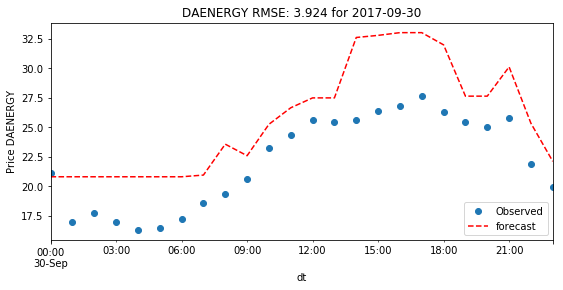

In [25]:
res, rmse = train_and_predict(df,'2017-09-30')

Working for date 2017-08-01
RMSE for AdaBoost Model:  3.48338681968
Working for date 2017-08-02
RMSE for AdaBoost Model:  1.66387310159
Working for date 2017-08-03
RMSE for AdaBoost Model:  1.67829878998
Working for date 2017-08-04
RMSE for AdaBoost Model:  1.63426912213
Working for date 2017-08-05
RMSE for AdaBoost Model:  2.15943656344
Working for date 2017-08-06
RMSE for AdaBoost Model:  1.42055090779
Working for date 2017-08-07
RMSE for AdaBoost Model:  2.3380801078
Working for date 2017-08-08
RMSE for AdaBoost Model:  1.28287586076
Working for date 2017-08-09
RMSE for AdaBoost Model:  2.06802539242
Working for date 2017-08-10
RMSE for AdaBoost Model:  1.75057410606
Working for date 2017-08-11
RMSE for AdaBoost Model:  1.75153947294
Working for date 2017-08-12
RMSE for AdaBoost Model:  1.17216274924
Working for date 2017-08-13
RMSE for AdaBoost Model:  1.2875624276
Working for date 2017-08-14
RMSE for AdaBoost Model:  4.08141316492
Working for date 2017-08-15
RMSE for AdaBoost Mode

/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  2.49400027044
Working for date 2017-08-23


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  1.54637336307
Working for date 2017-08-24


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  1.97595905832
Working for date 2017-08-25


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  1.2859527106
Working for date 2017-08-26


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  3.36368994707
Working for date 2017-08-27


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  1.78085282611
Working for date 2017-08-28


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  2.3781005844
Working for date 2017-08-29


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  1.56208290366
Working for date 2017-08-30


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  1.88608333337
Working for date 2017-08-31


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  0.883021515444


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


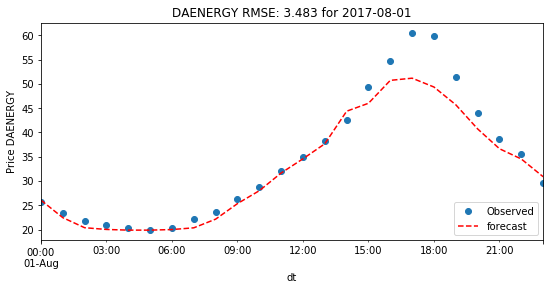

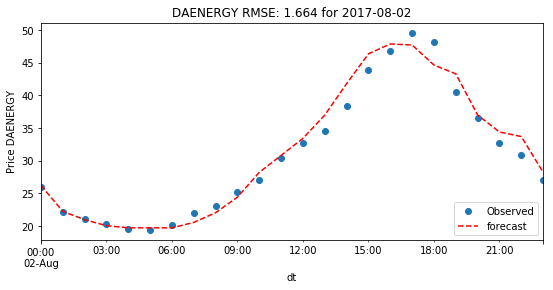

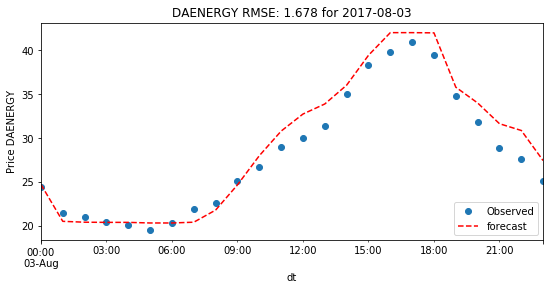

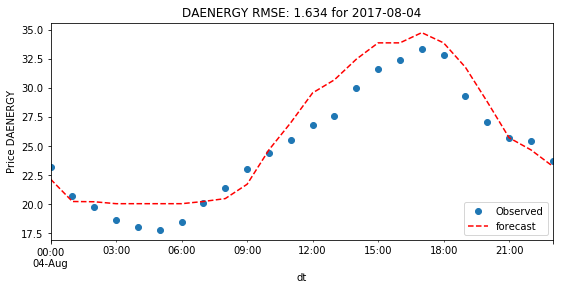

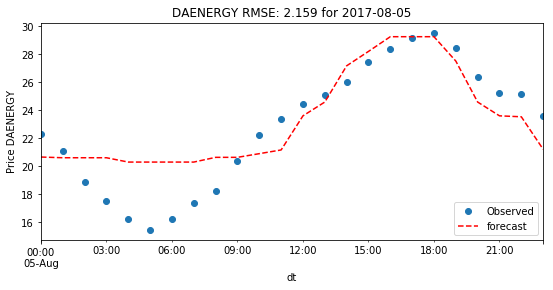

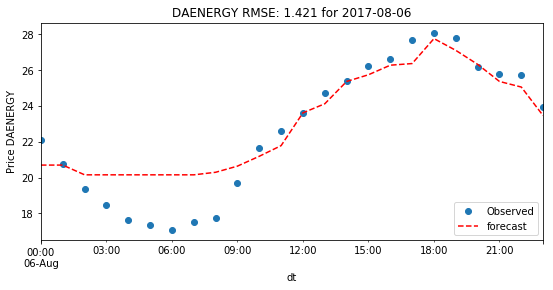

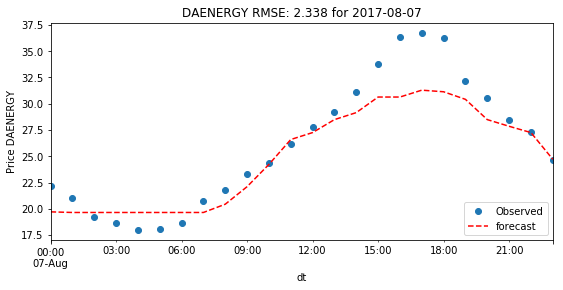

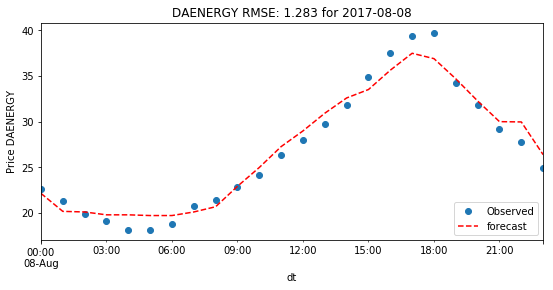

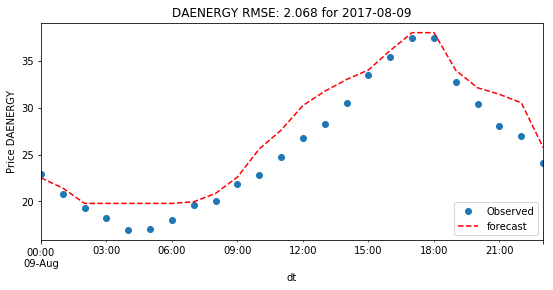

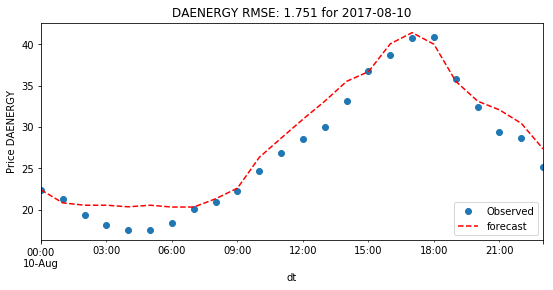

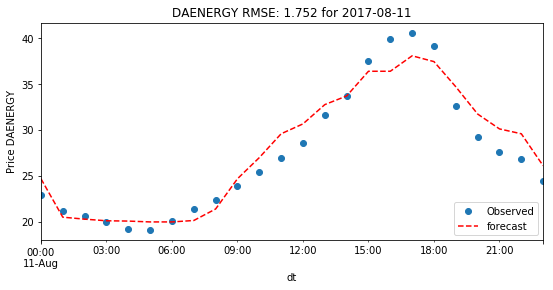

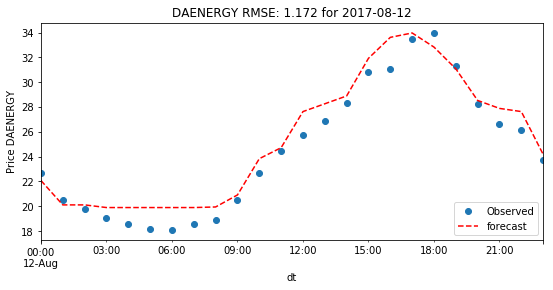

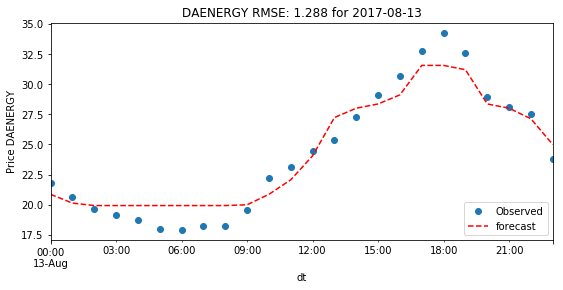

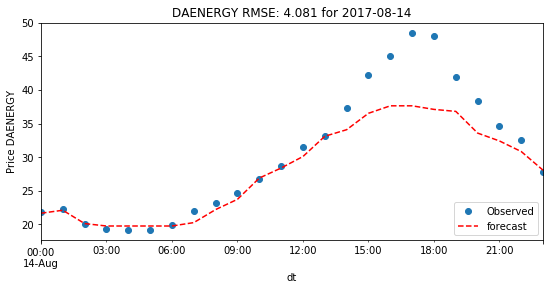

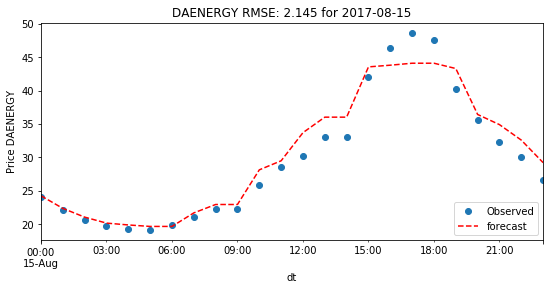

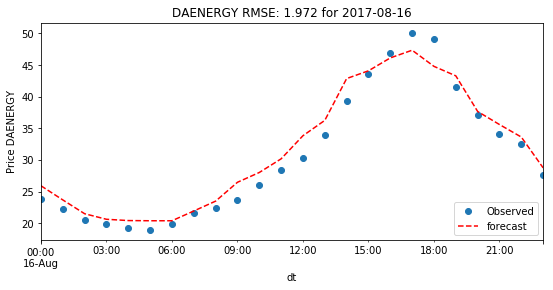

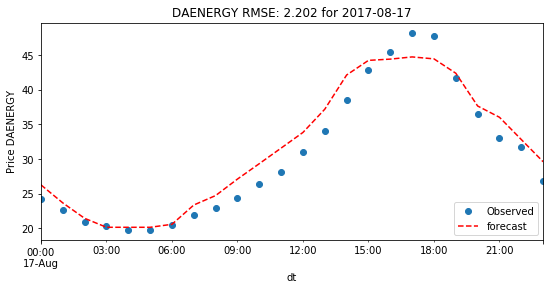

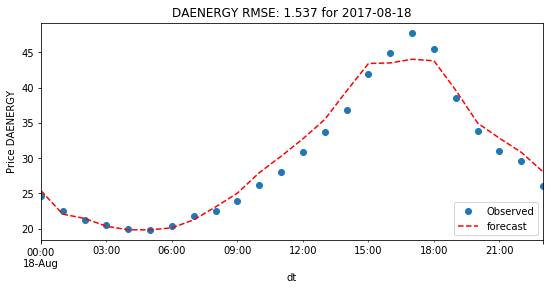

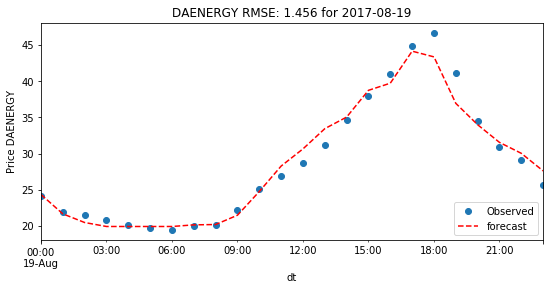

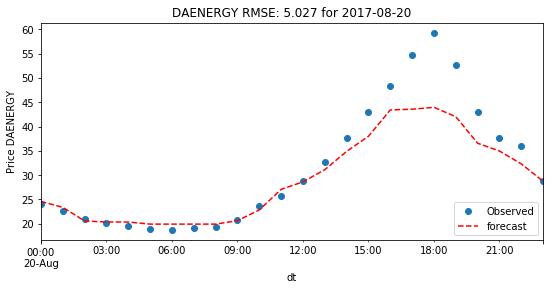

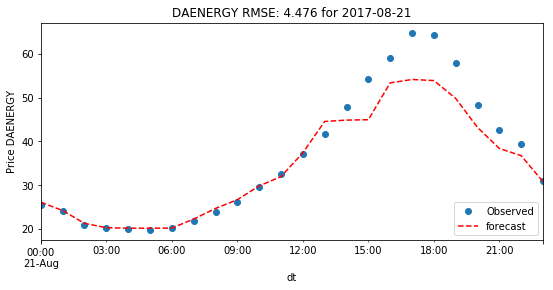

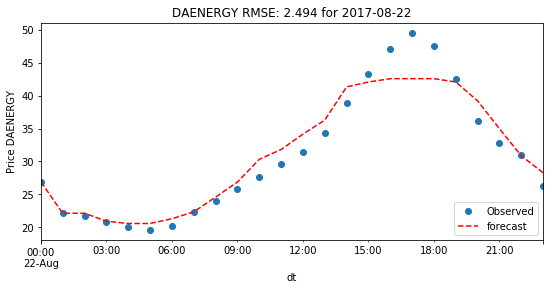

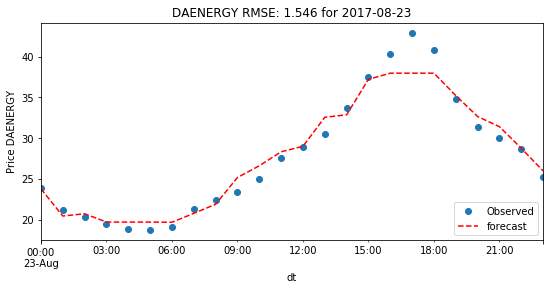

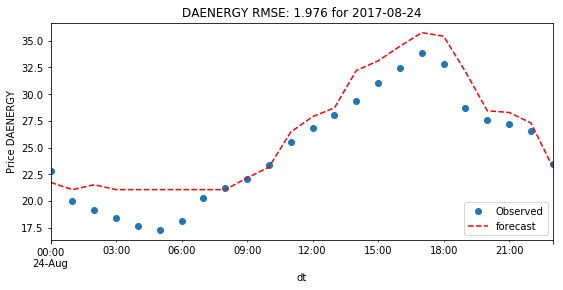

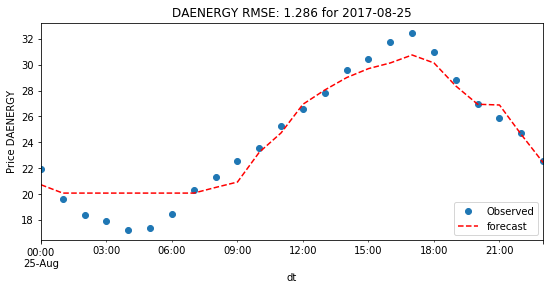

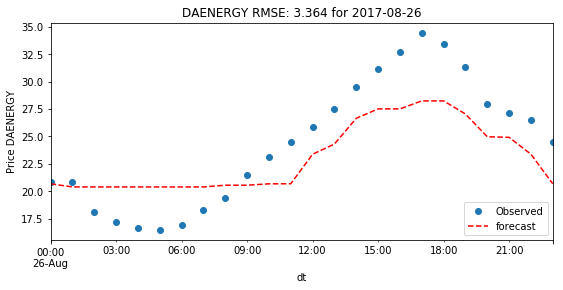

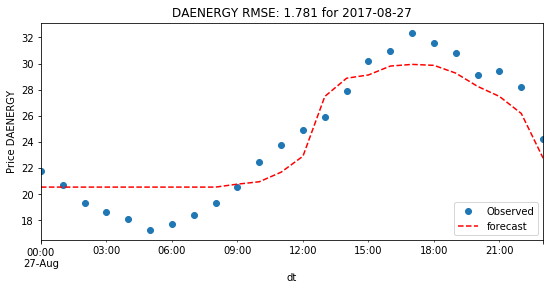

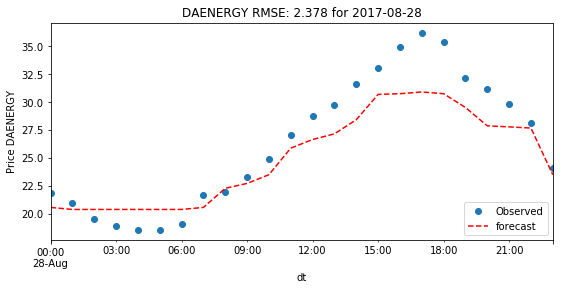

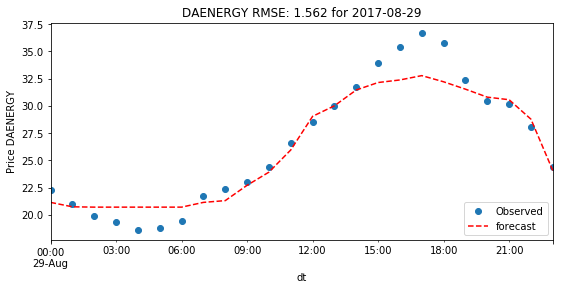

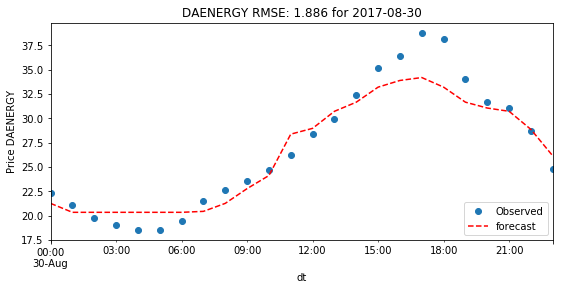

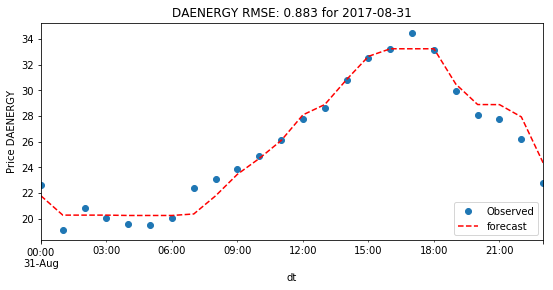

In [26]:
rmses = []
for dt in create_date_range('2017-08-01', '2017-08-31'):
    print('Working for date {}'.format(dt))
    res, rmse = train_and_predict(df,dt)
    rmses.append(rmse)

Text(0,0.5,'RMSE')

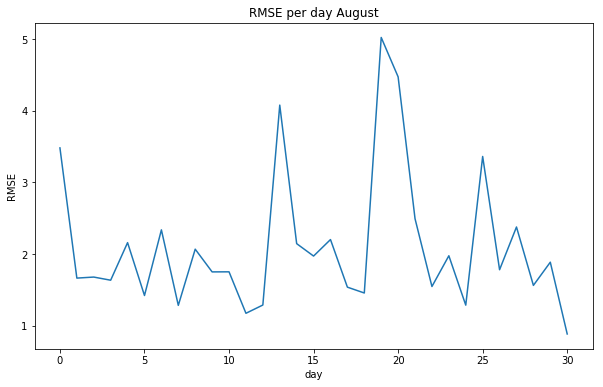

In [27]:
plt.figure(figsize = (10,6))
plt.plot(rmses)
plt.title('RMSE per day August')
plt.xlabel('day')
plt.ylabel('RMSE')

Working for date 2017-09-01
RMSE for AdaBoost Model:  2.61757644326
Working for date 2017-09-02
RMSE for AdaBoost Model:  2.2105052199
Working for date 2017-09-03
RMSE for AdaBoost Model:  2.16620642805
Working for date 2017-09-04
RMSE for AdaBoost Model:  3.1555339776
Working for date 2017-09-05
RMSE for AdaBoost Model:  1.91945003517
Working for date 2017-09-06
RMSE for AdaBoost Model:  2.32905065031
Working for date 2017-09-07
RMSE for AdaBoost Model:  1.40187594395
Working for date 2017-09-08
RMSE for AdaBoost Model:  1.12737411387
Working for date 2017-09-09
RMSE for AdaBoost Model:  2.07917590056
Working for date 2017-09-10
RMSE for AdaBoost Model:  3.03263689642
Working for date 2017-09-11
RMSE for AdaBoost Model:  4.54429803583
Working for date 2017-09-12
RMSE for AdaBoost Model:  2.00329551017
Working for date 2017-09-13
RMSE for AdaBoost Model:  2.4642648802
Working for date 2017-09-14
RMSE for AdaBoost Model:  3.58677213047
Working for date 2017-09-15
RMSE for AdaBoost Model

/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  10.3394988745
Working for date 2017-09-23


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  9.44449919282
Working for date 2017-09-24


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  8.64074037596
Working for date 2017-09-25


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  13.8469035365
Working for date 2017-09-26


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  10.2754098043
Working for date 2017-09-27


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  12.6447716301
Working for date 2017-09-28


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  2.46046937296
Working for date 2017-09-29


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  2.64524353153
Working for date 2017-09-30


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  4.00134725765


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Text(0,0.5,'RMSE')

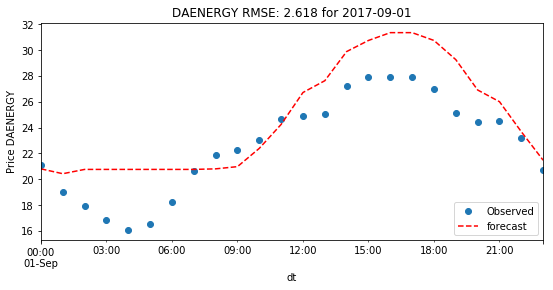

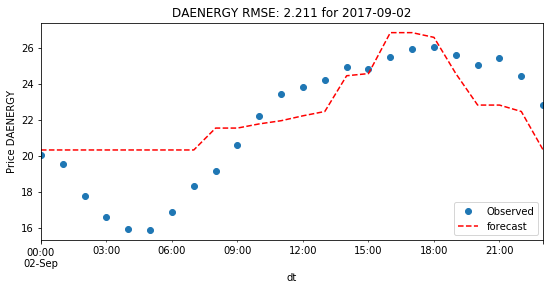

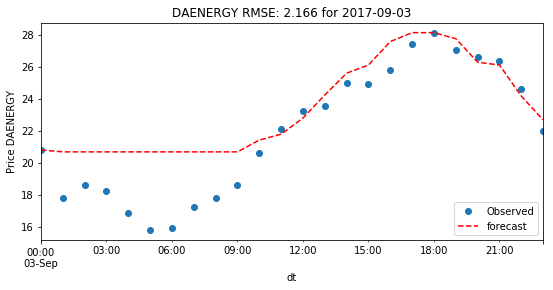

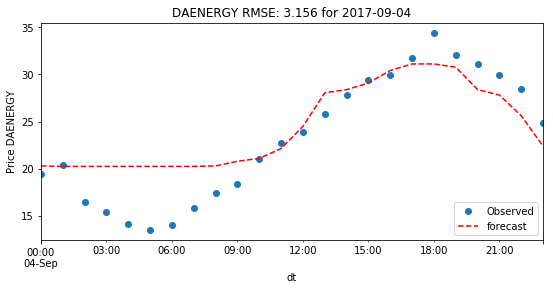

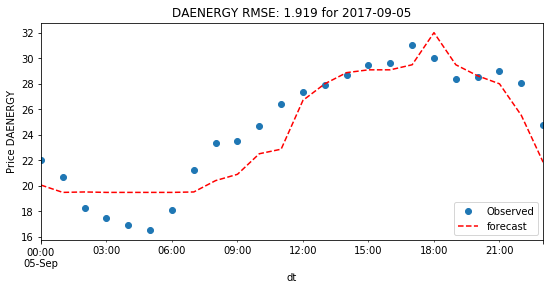

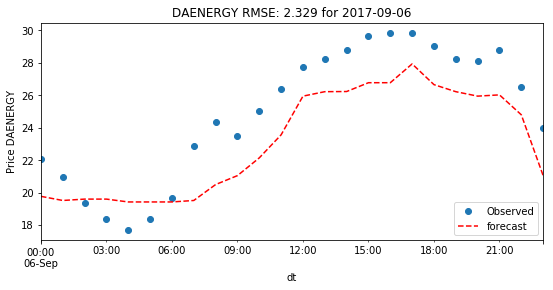

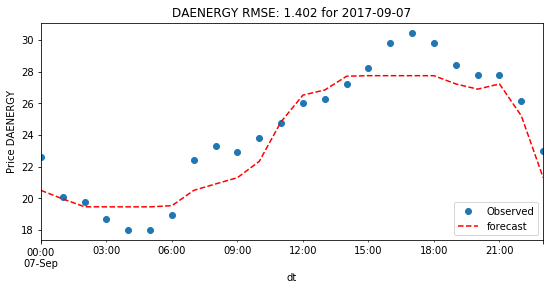

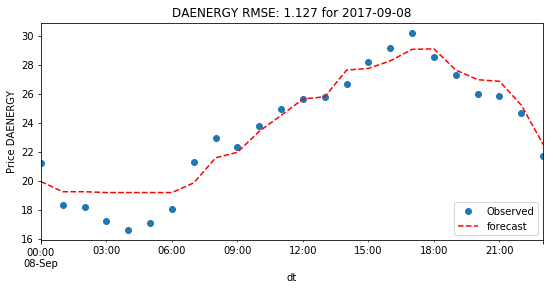

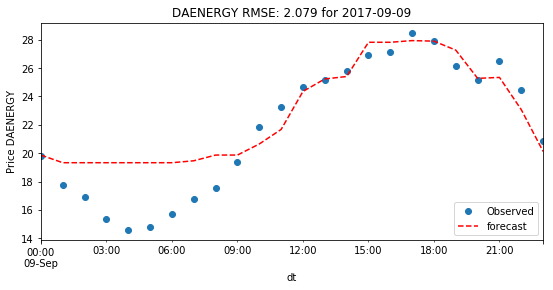

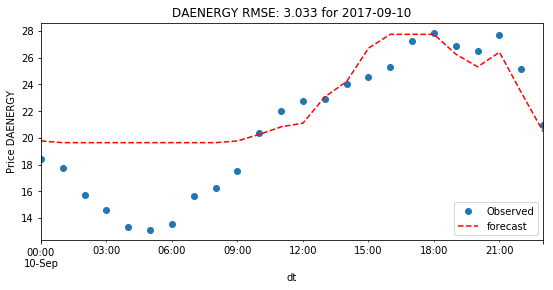

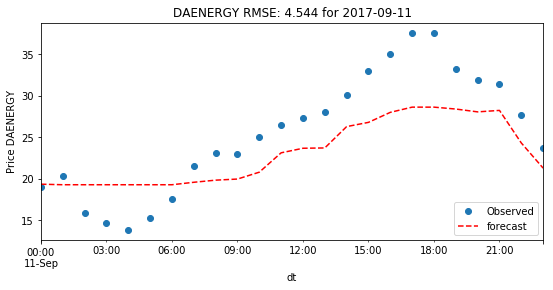

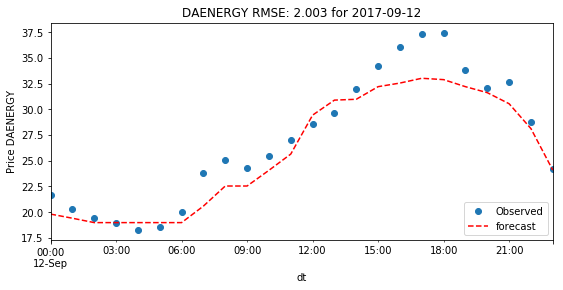

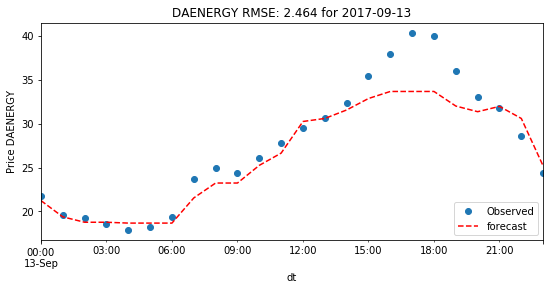

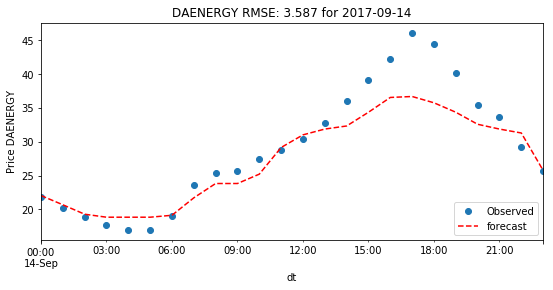

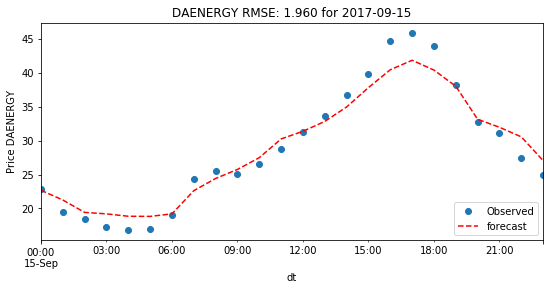

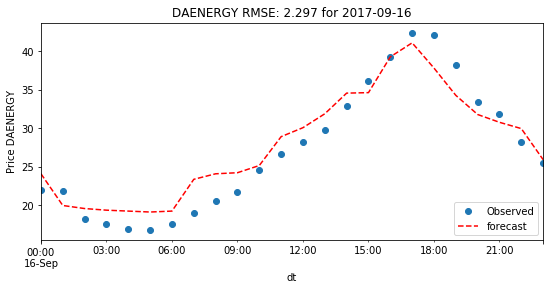

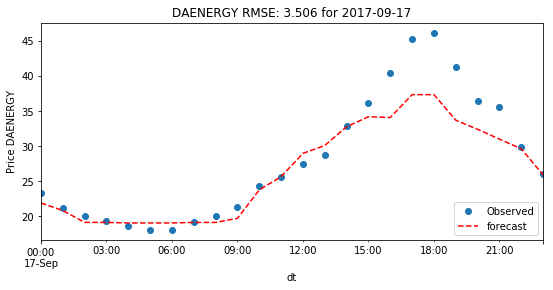

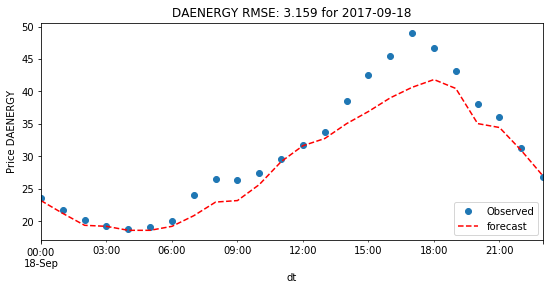

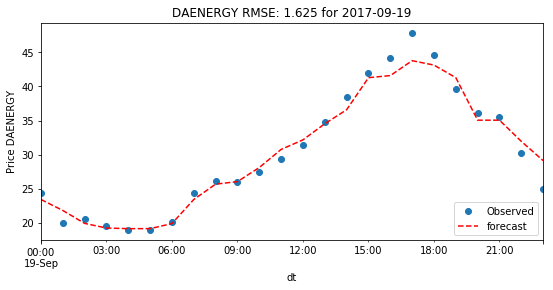

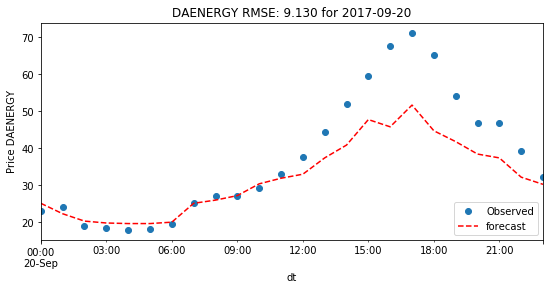

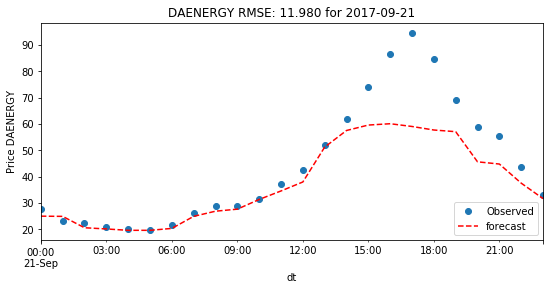

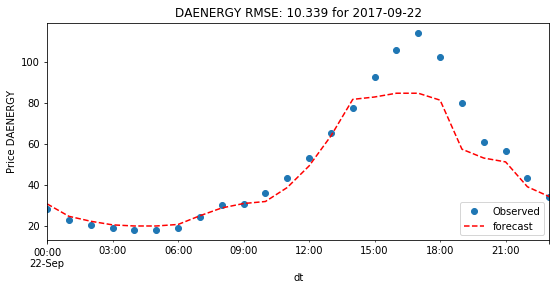

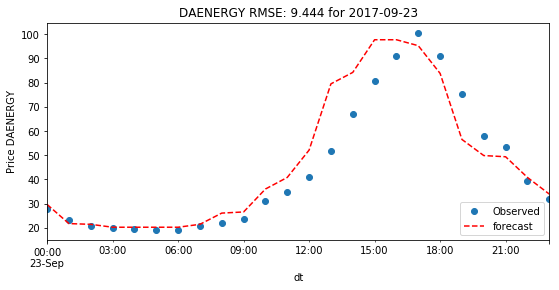

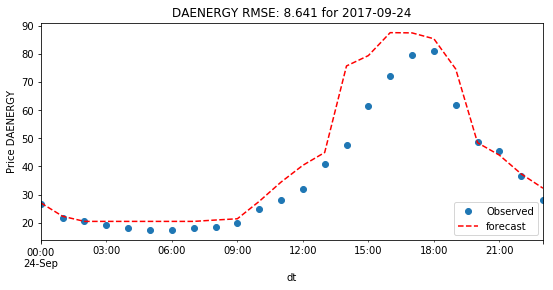

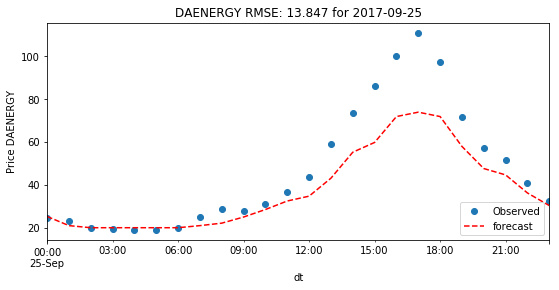

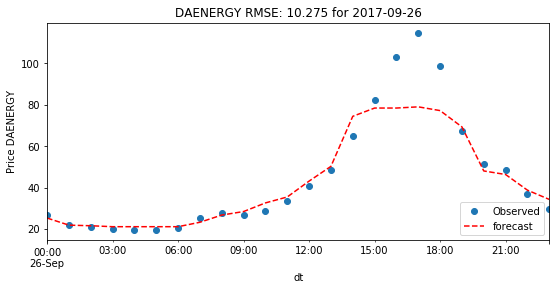

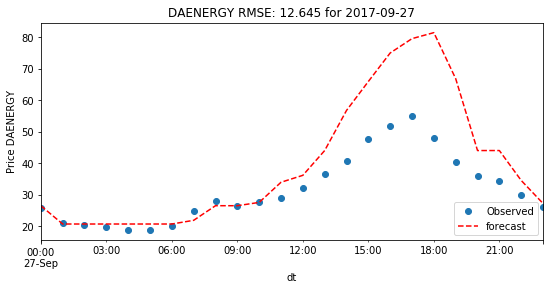

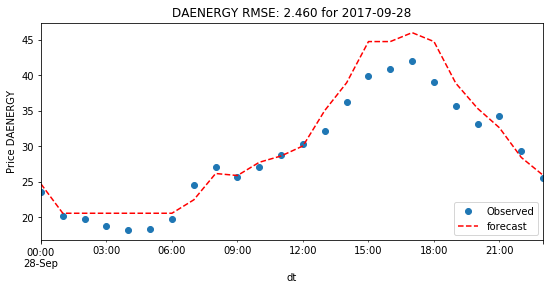

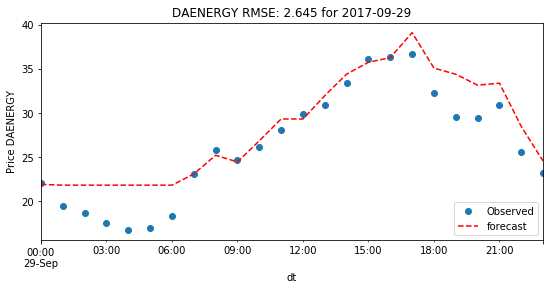

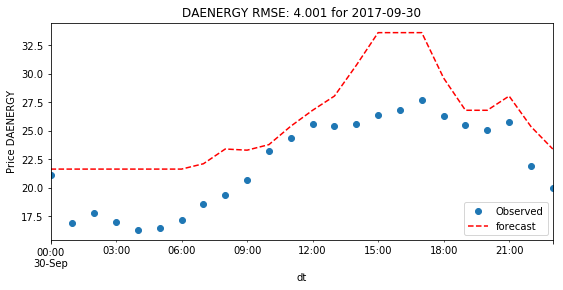

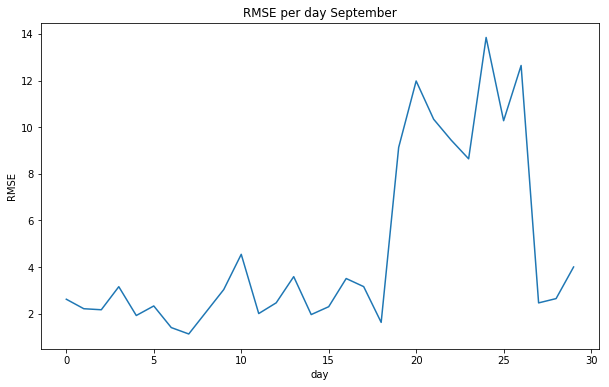

In [28]:
rmses = []
for dt in create_date_range('2017-09-01', '2017-09-30'):
    print('Working for date {}'.format(dt))
    res, rmse = train_and_predict(df,dt)
    rmses.append(rmse)

plt.figure(figsize = (10,6))
plt.plot(rmses)
plt.title('RMSE per day September')
plt.xlabel('day')
plt.ylabel('RMSE')

In [29]:
df['2017-09-30':'2017-10-01']

REGION,TRADEDATE,HOUROFWEEK,CYWG,K2G4,KABE,KABI,KACT,KACY,KADS,KAKR,...,KVCT,KWRI,KYNG,KZZV,LOAD,DAENERGY,RTENERGY,ISOWIND,OUTAGE,hourofday
dt,,,,,,,,,,,,,,,,,,,,,
2017-09-30 00:00:00,2017-09-29,144,47,48,55,62,68,58,69,52,...,75,56,50,51,65683,21.15,21.13,4990.698,34820,00:00:00
2017-09-30 01:00:00,2017-09-30,145,58,38,47,64,66,54,68,43,...,72,51,41,44,59651,16.94,14.16,10139.111,38930,01:00:00
2017-09-30 02:00:00,2017-09-30,146,45,45,53,61,67,58,68,51,...,73,56,48,49,59139,17.76,14.42,5296.367,34820,02:00:00
2017-09-30 03:00:00,2017-09-30,147,44,44,52,60,66,58,67,50,...,73,56,48,48,57481,16.98,16.42,5348.166,34820,03:00:00
2017-09-30 04:00:00,2017-09-30,148,44,43,51,60,65,58,66,49,...,72,55,47,47,56600,16.27,13.82,5391.917,34820,04:00:00
2017-09-30 05:00:00,2017-09-30,149,43,41,51,62,65,56,65,48,...,71,54,45,45,56047,16.43,14.51,5415.679,34820,05:00:00
2017-09-30 06:00:00,2017-09-30,150,43,40,50,61,64,55,65,48,...,70,53,45,45,56713,17.20,14.63,5540.652,34820,06:00:00
2017-09-30 07:00:00,2017-09-30,151,43,40,51,61,64,55,65,48,...,70,54,45,46,58551,18.58,16.37,5757.243,34820,07:00:00
2017-09-30 08:00:00,2017-09-30,152,46,41,55,62,66,58,66,50,...,70,57,47,49,60315,19.36,18.56,6005.349,34820,08:00:00
